# Disjoint Groups Experiment Analysis

This notebook analyzes the results from the disjoint groups transformation experiment, providing detailed insights into:
- Portfolio compositions (initial, target, final weights)
- Performance metrics across different policies and time periods
- Asset-level analysis and weight evolution
- Policy hyperparameters and their impact

## Setup and Data Loading

In [29]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load the experiment results
results_path = Path("./main_experiments/disjoint_groups_output/experiment_results.csv")
if results_path.exists():
    df = pd.read_csv(results_path)
    print(f"Loaded {len(df)} experiment results")
    print(f"Scenarios: {df['scenario'].unique()}")
    print(f"Policies: {df['policy'].unique()}")
    print(f"Periods: {sorted(df['period'].unique())}")
else:
    print("Results file not found. Please run the experiment first.")
    df = pd.DataFrame()

Loaded 24 experiment results
Scenarios: ['Low_Vol_to_High_Vol' 'High_Sharpe_to_Low_Correlation']
Policies: ['Uniform' 'Dynamic_Uniform' 'Univariate_Tracking']
Periods: [np.int64(5), np.int64(10), np.int64(20), np.int64(30)]


In [30]:
df

,scenario,policy,period,sharpe,return,volatility,turnover,max_leverage,max_drawdown,tracking_error,initial_weights,target_weights,final_weights,policy_params,risk_target
0,Low_Vol_to_High_Vol,Uniform,5,-1.047719,-0.036039,0.044629,2.395124,0.150064,-0.007458,0.025354,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006619, ""ALGN"": 0.006572, ""AMD"": 0.0...",{},0.08
1,Low_Vol_to_High_Vol,Dynamic_Uniform,5,-0.753633,-0.022546,0.044116,1.870964,0.150038,-0.006995,0.017339,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006619, ""ALGN"": 0.006572, ""AMD"": 0.0...",{},0.08
2,Low_Vol_to_High_Vol,Univariate_Tracking,5,0.385534,0.017917,0.018849,1.143866,0.091484,-0.002003,0.009067,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.003682, ""ALGN"": 0.000558, ""AMD"": 0.0...","{""risk_aversion"": 1.0}",0.08
3,Low_Vol_to_High_Vol,Uniform,10,1.412310,0.074344,0.044545,1.394319,0.150035,-0.007930,0.013687,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006424, ""ALGN"": 0.006121, ""AMD"": 0.0...",{},0.08
4,Low_Vol_to_High_Vol,Dynamic_Uniform,10,1.449290,0.075700,0.044344,1.098861,0.150025,-0.007859,0.009173,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006424, ""ALGN"": 0.006121, ""AMD"": 0.0...",{},0.08
5,Low_Vol_to_High_Vol,Univariate_Tracking,10,2.458415,0.073625,0.025299,0.751663,0.120791,-0.003180,0.005837,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.004365, ""ALGN"": 0.002197, ""AMD"": 0.0...","{""risk_aversion"": 1.0}",0.08
6,Low_Vol_to_High_Vol,Uniform,20,4.073595,0.175373,0.039704,0.831897,0.150023,-0.004941,0.007752,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006323, ""ALGN"": 0.00627, ""AMD"": 0.00...",{},0.08
7,Low_Vol_to_High_Vol,Dynamic_Uniform,20,4.131515,0.177221,0.039594,0.675971,0.150014,-0.004530,0.005369,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006323, ""ALGN"": 0.00627, ""AMD"": 0.00...",{},0.08
8,Low_Vol_to_High_Vol,Univariate_Tracking,20,3.385214,0.094444,0.023876,0.419947,0.139109,-0.003425,0.003238,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.005156, ""ALGN"": 0.004335, ""AMD"": 0.0...","{""risk_aversion"": 1.0}",0.08
9,Low_Vol_to_High_Vol,Uniform,30,1.718017,0.079345,0.037698,0.586239,0.150010,-0.012011,0.005543,"{""AEE"": 0.002174, ""AEP"": 0.002174, ""AJG"": 0.00...","{""ALB"": 0.006522, ""ALGN"": 0.006522, ""AMD"": 0.0...","{""ALB"": 0.006734, ""ALGN"": 0.006389, ""AMD"": 0.0...",{},0.08


## Data Preprocessing and Exploration

In [31]:
if not df.empty:
    # Parse JSON columns
    for col in ['initial_weights', 'target_weights', 'final_weights', 'policy_params']:
        df[f'{col}_parsed'] = df[col].apply(lambda x: json.loads(x) if pd.notna(x) else {})
    
    # Extract key metrics
    df['total_initial_weight'] = df['initial_weights_parsed'].apply(lambda x: sum(x.values()) if x else 0)
    df['total_target_weight'] = df['target_weights_parsed'].apply(lambda x: sum(x.values()) if x else 0)
    df['total_final_weight'] = df['final_weights_parsed'].apply(lambda x: sum(x.values()) if x else 0)
    
    # Number of assets in each portfolio
    df['n_initial_assets'] = df['initial_weights_parsed'].apply(len)
    df['n_target_assets'] = df['target_weights_parsed'].apply(len)
    df['n_final_assets'] = df['final_weights_parsed'].apply(len)
    
    print("Data preprocessing complete!")
    print(f"\nSample of processed data:")
    display(df[['scenario', 'policy', 'period', 'sharpe', 'n_initial_assets', 'n_target_assets']])

Data preprocessing complete!

Sample of processed data:


,scenario,policy,period,sharpe,n_initial_assets,n_target_assets
0,Low_Vol_to_High_Vol,Uniform,5,-1.047719,23,23
1,Low_Vol_to_High_Vol,Dynamic_Uniform,5,-0.753633,23,23
2,Low_Vol_to_High_Vol,Univariate_Tracking,5,0.385534,23,23
3,Low_Vol_to_High_Vol,Uniform,10,1.412310,23,23
4,Low_Vol_to_High_Vol,Dynamic_Uniform,10,1.449290,23,23
5,Low_Vol_to_High_Vol,Univariate_Tracking,10,2.458415,23,23
6,Low_Vol_to_High_Vol,Uniform,20,4.073595,23,23
7,Low_Vol_to_High_Vol,Dynamic_Uniform,20,4.131515,23,23
8,Low_Vol_to_High_Vol,Univariate_Tracking,20,3.385214,23,23
9,Low_Vol_to_High_Vol,Uniform,30,1.718017,23,23


## Portfolio Composition Analysis

In [33]:
def display_portfolio_composition(row, portfolio_type='initial'):
    """Display actual portfolio composition for a given row."""
    weights = row[f'{portfolio_type}_weights_parsed']
    if not weights:
        print(f"{portfolio_type.capitalize()} Portfolio: Empty")
        return
    
    # Sort by weight (descending)
    sorted_weights = sorted(weights.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print(f"{portfolio_type.capitalize()} Portfolio ({len(weights)} assets, total weight: {sum(weights.values()):.4f}):")
    print("Asset".ljust(15) + "Weight".ljust(10) + "Type")
    print("-" * 35)
    
    for asset, weight in sorted_weights:
        asset_type = "LONG" if weight > 0 else "SHORT"
        print(f"{asset[:14].ljust(15)}{weight:8.4f}  {asset_type}")
    print()

if not df.empty:
    print("=== PORTFOLIO COMPOSITIONS FOR ALL EXPERIMENTS ===\n")
    
    for idx, row in df.iterrows():
        print(f"Experiment {idx+1}: {row['scenario']} - {row['policy']} - {row['period']}d")
        print(f"Sharpe: {row['sharpe']:.3f}, Turnover: {row['turnover']:.3f}")
        print("=" * 60)
        
        # Display all three portfolios
        display_portfolio_composition(row, 'initial')
        display_portfolio_composition(row, 'target')
        display_portfolio_composition(row, 'final')
        
        print("\n" + "="*80 + "\n")

=== PORTFOLIO COMPOSITIONS FOR ALL EXPERIMENTS ===

Experiment 1: Low_Vol_to_High_Vol - Uniform - 5d
Sharpe: -1.048, Turnover: 2.395
Initial Portfolio (23 assets, total weight: 0.0500):
Asset          Weight    Type
-----------------------------------
AEE              0.0022  LONG
AEP              0.0022  LONG
AJG              0.0022  LONG
AON              0.0022  LONG
ATO              0.0022  LONG
BDX              0.0022  LONG
BRK.B            0.0022  LONG
CB               0.0022  LONG
CL               0.0022  LONG
COST             0.0022  LONG
D                0.0022  LONG
DTE              0.0022  LONG
DUK              0.0022  LONG
ED               0.0022  LONG
EVRG             0.0022  LONG
GD               0.0022  LONG
GIS              0.0022  LONG
HON              0.0022  LONG
HSY              0.0022  LONG
JKHY             0.0022  LONG
JNJ              0.0022  LONG
K                0.0022  LONG
KO               0.0022  LONG

Target Portfolio (23 assets, total weight: 0.1500):
Asset

## Performance Analysis by Scenario

In [19]:
if not df.empty:
    # Performance summary by scenario
    scenario_summary = df.groupby('scenario').agg({
        'sharpe': ['mean', 'std', 'min', 'max'],
        'return': ['mean', 'std'],
        'volatility': ['mean', 'std'],
        'turnover': ['mean', 'std'],
        'tracking_error': ['mean', 'std']
    }).round(4)
    
    print("Performance Summary by Scenario:")
    display(scenario_summary)
    
    # Performance by policy and period
    policy_period_summary = df.groupby(['scenario', 'policy', 'period']).agg({
        'sharpe': 'mean',
        'return': 'mean',
        'volatility': 'mean',
        'turnover': 'mean',
        'tracking_error': 'mean'
    }).round(4)
    
    print("\nDetailed Performance by Policy and Period:")
    display(policy_period_summary)

Performance Summary by Scenario:


sharpe                          return  \
                                  mean     std     min     max    mean   
scenario                                                                 
High_Sharpe_to_Low_Correlation -0.8509  3.2385 -5.1351  3.9270 -0.0105   
Low_Vol_to_High_Vol             1.5801  1.7346 -1.0477  4.1315  0.0670   

                                       volatility         turnover          \
                                   std       mean     std     mean     std   
scenario                                                                     
High_Sharpe_to_Low_Correlation  0.0520     0.0124  0.0063   0.7286  0.5494   
Low_Vol_to_High_Vol             0.0667     0.0356  0.0093   0.9949  0.6299   

                               tracking_error          
                                         mean     std  
scenario                                               
High_Sharpe_to_Low_Correlation         0.0075  0.0071  
Low_Vol_to_High_Vol                    0.0090  0.0067


Detailed Performance by Policy and Period:


sharpe  return  \
scenario                       policy              period                   
High_Sharpe_to_Low_Correlation Dynamic_Uniform     5       3.9270  0.0641   
                                                   10      2.7772  0.0382   
                                                   20      0.8485  0.0222   
                                                   30     -3.2362 -0.0286   
                               Uniform             5      -5.1351 -0.1295   
                                                   10     -4.0567 -0.0554   
                                                   20     -2.1093 -0.0169   
                                                   30     -3.4865 -0.0435   
                               Univariate_Tracking 5       2.8105  0.0221   
                                                   10      2.0384  0.0221   
                                                   20     -0.3307  0.0115   
                                                   30     -4.2582 -0.0322   
Low_Vol_to_High_Vol            Dynamic_Uniform     5      -0.7536 -0.0225   
                                                   10      1.4493  0.0757   
                                                   20      4.1315  0.1772   
                                                   30      1.7405  0.0801   
                               Uniform             5      -1.0477 -0.0360   
                                                   10      1.4123  0.0743   
                                                   20      4.0736  0.1754   
                                                   30      1.7180  0.0793   
                               Univariate_Tracking 5       0.3855  0.0179   
                                                   10      2.4584  0.0736   
                                                   20      3.3852  0.0944   
                                                   30      0.0081  0.0148   

                                                           volatility  \
scenario                       policy              period               
High_Sharpe_to_Low_Correlation Dynamic_Uniform     5           0.0137   
                                                   10          0.0096   
                                                   20          0.0101   
                                                   30          0.0133   
                               Uniform             5           0.0274   
                                                   10          0.0165   
                                                   20          0.0145   
                                                   30          0.0166   
                               Univariate_Tracking 5           0.0041   
                                                   10          0.0052   
                                                   20          0.0065   
                                                   30          0.0109   
Low_Vol_to_High_Vol            Dynamic_Uniform     5           0.0441   
                                                   10          0.0443   
                                                   20          0.0396   
                                                   30          0.0377   
                               Uniform             5           0.0446   
                                                   10          0.0445   
                                                   20          0.0397   
                                                   30          0.0377   
                               Univariate_Tracking 5           0.0188   
                                                   10          0.0253   
                                                   20          0.0239   
                                                   30          0.0269   

                                                           turnover  \
scenario                       policy              period             
High_Sharpe_to_

## Portfolio Weight Evolution Analysis

In [20]:
def analyze_weight_evolution(row):
    """Analyze how weights evolved from initial to final."""
    initial = row['initial_weights_parsed']
    target = row['target_weights_parsed']
    final = row['final_weights_parsed']
    
    # Get all unique assets
    all_assets = set(initial.keys()) | set(target.keys()) | set(final.keys())
    
    evolution_data = []
    for asset in all_assets:
        evolution_data.append({
            'asset': asset,
            'initial_weight': initial.get(asset, 0),
            'target_weight': target.get(asset, 0),
            'final_weight': final.get(asset, 0),
            'weight_change': final.get(asset, 0) - initial.get(asset, 0),
            'target_deviation': abs(final.get(asset, 0) - target.get(asset, 0))
        })
    
    return pd.DataFrame(evolution_data)

if not df.empty:
    # Analyze a specific experiment result
    sample_row = df.iloc[0]  # First result
    
    print(f"Analyzing weight evolution for: {sample_row['scenario']} - {sample_row['policy']} - {sample_row['period']}d")
    
    weight_evolution = analyze_weight_evolution(sample_row)
    
    print("\nWeight Evolution Summary:")
    print(f"Total assets involved: {len(weight_evolution)}")
    print(f"Assets with non-zero final weight: {len(weight_evolution[weight_evolution['final_weight'] != 0])}")
    print(f"Average target deviation: {weight_evolution['target_deviation'].mean():.6f}")
    
    # Show assets with significant changes
    significant_changes = weight_evolution[abs(weight_evolution['weight_change']) > 0.001]
    if not significant_changes.empty:
        print("\nAssets with significant weight changes:")
        display(significant_changes.sort_values('weight_change', ascending=False))

Analyzing weight evolution for: Low_Vol_to_High_Vol - Uniform - 5d

Weight Evolution Summary:
Total assets involved: 46
Assets with non-zero final weight: 23
Average target deviation: 0.000051

Assets with significant weight changes:


,asset,initial_weight,target_weight,final_weight,weight_change,target_deviation
38,ENPH,0.000000,0.006522,0.006828,0.006828,0.000306
33,FSLR,0.000000,0.006522,0.006698,0.006698,0.000176
3,FTNT,0.000000,0.006522,0.006639,0.006639,0.000117
12,DVN,0.000000,0.006522,0.006624,0.006624,0.000102
14,ALB,0.000000,0.006522,0.006619,0.006619,0.000097
40,ANET,0.000000,0.006522,0.006591,0.006591,0.000069
20,ALGN,0.000000,0.006522,0.006572,0.006572,0.000050
11,GE,0.000000,0.006522,0.006551,0.006551,0.000029
28,BLDR,0.000000,0.006522,0.006549,0.006549,0.000027
29,HES,0.000000,0.006522,0.006543,0.006543,0.000021


## Policy Hyperparameter Analysis

In [21]:
if not df.empty:
    # Extract policy parameters
    policy_params_df = pd.DataFrame()
    
    for idx, row in df.iterrows():
        params = row['policy_params_parsed']
        if params:
            param_row = pd.Series(params)
            param_row['scenario'] = row['scenario']
            param_row['policy'] = row['policy']
            param_row['period'] = row['period']
            param_row['sharpe'] = row['sharpe']
            policy_params_df = pd.concat([policy_params_df, param_row.to_frame().T], ignore_index=True)
    
    if not policy_params_df.empty:
        print("Policy Hyperparameters Analysis:")
        
        # Show unique parameters by policy
        for policy in policy_params_df['policy'].unique():
            policy_data = policy_params_df[policy_params_df['policy'] == policy]
            print(f"\n{policy}:")
            param_cols = [col for col in policy_data.columns if col not in ['scenario', 'policy', 'period', 'sharpe']]
            if param_cols:
                for param in param_cols:
                    unique_vals = policy_data[param].unique()
                    print(f"  {param}: {unique_vals}")
            else:
                print("  No hyperparameters found")
        
        # Analyze impact of hyperparameters on performance
        if 'risk_aversion' in policy_params_df.columns:
            print("\nRisk Aversion Impact on Sharpe Ratio:")
            risk_impact = policy_params_df.groupby('risk_aversion')['sharpe'].agg(['mean', 'std', 'count'])
            display(risk_impact)

Policy Hyperparameters Analysis:

Univariate_Tracking:
  risk_aversion: [1.0]

Risk Aversion Impact on Sharpe Ratio:


,mean,std,count
risk_aversion,,,
1.0,0.812151,2.468985,8


## Visualization: Performance Comparison

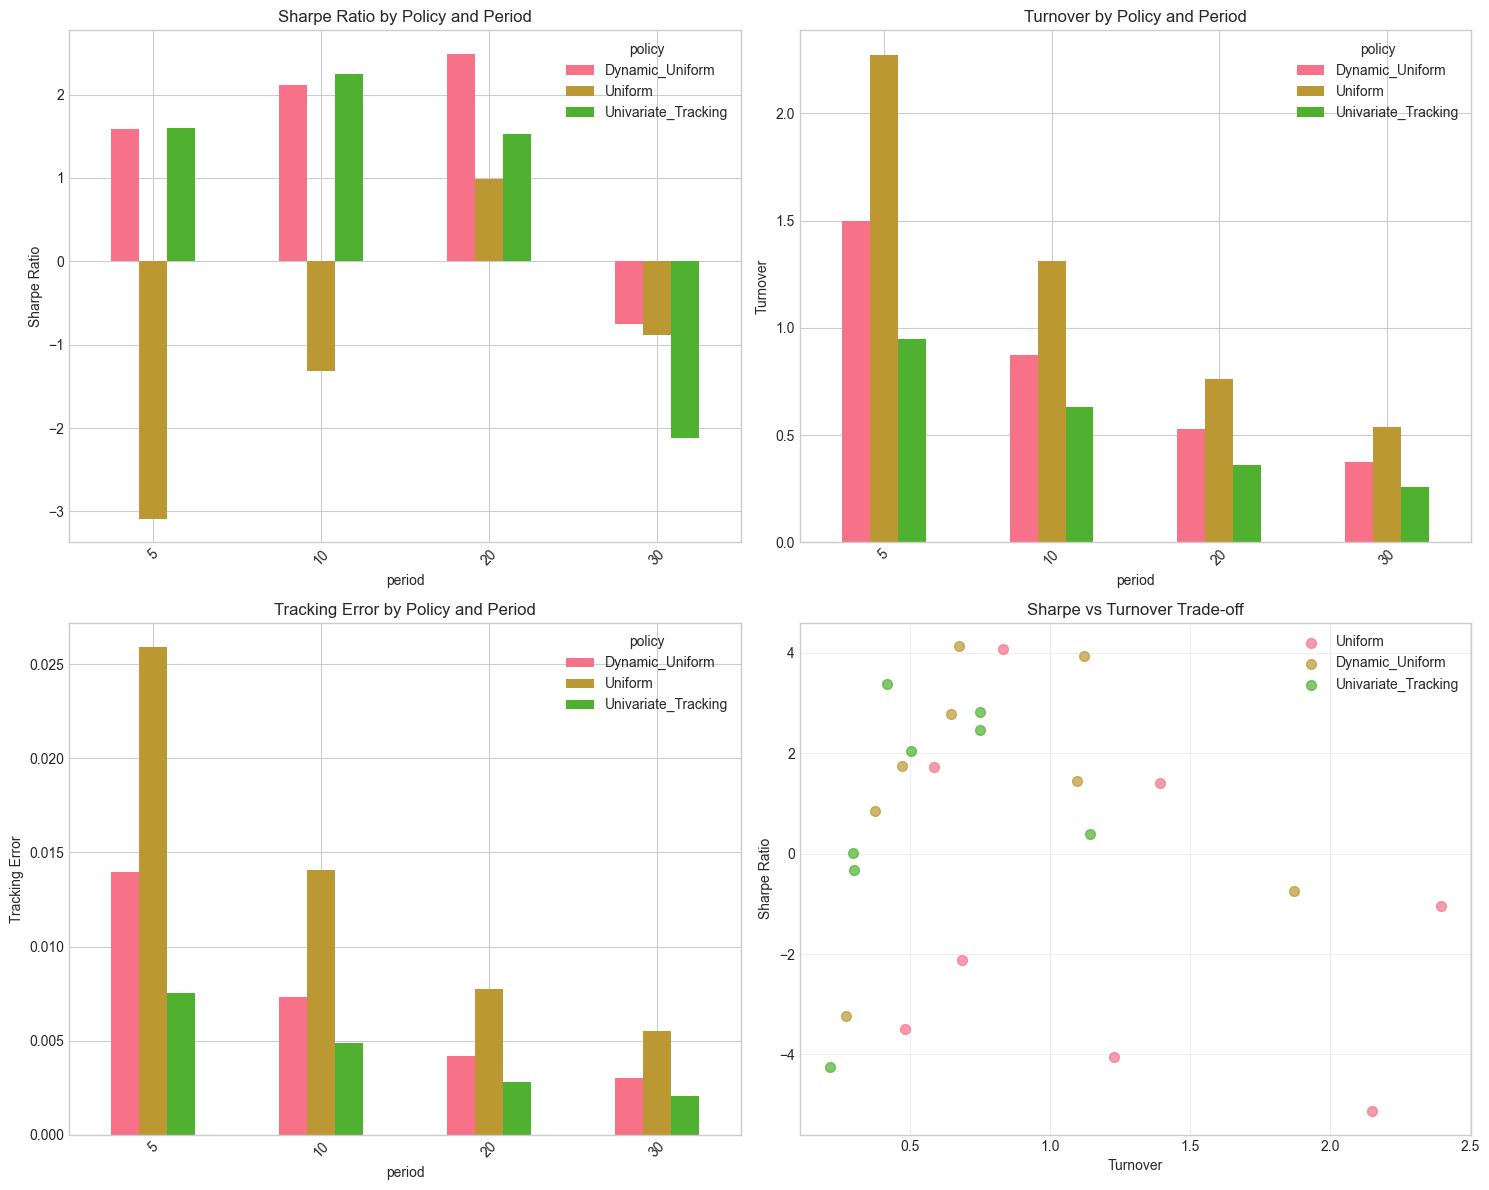

In [22]:
if not df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Sharpe ratio by policy and period
    pivot_sharpe = df.pivot_table(values='sharpe', index='period', columns='policy', aggfunc='mean')
    pivot_sharpe.plot(kind='bar', ax=axes[0,0], title='Sharpe Ratio by Policy and Period')
    axes[0,0].set_ylabel('Sharpe Ratio')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Turnover by policy and period
    pivot_turnover = df.pivot_table(values='turnover', index='period', columns='policy', aggfunc='mean')
    pivot_turnover.plot(kind='bar', ax=axes[0,1], title='Turnover by Policy and Period')
    axes[0,1].set_ylabel('Turnover')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Tracking error by policy and period
    pivot_tracking = df.pivot_table(values='tracking_error', index='period', columns='policy', aggfunc='mean')
    pivot_tracking.plot(kind='bar', ax=axes[1,0], title='Tracking Error by Policy and Period')
    axes[1,0].set_ylabel('Tracking Error')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Sharpe vs Turnover scatter
    for policy in df['policy'].unique():
        policy_data = df[df['policy'] == policy]
        axes[1,1].scatter(policy_data['turnover'], policy_data['sharpe'], 
                         label=policy, alpha=0.7, s=50)
    axes[1,1].set_xlabel('Turnover')
    axes[1,1].set_ylabel('Sharpe Ratio')
    axes[1,1].set_title('Sharpe vs Turnover Trade-off')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Detailed Portfolio Analysis

In [23]:
def detailed_portfolio_analysis(scenario_name, policy_name, period):
    """Perform detailed analysis of a specific experiment result."""
    
    # Find the specific result
    mask = (df['scenario'] == scenario_name) & (df['policy'] == policy_name) & (df['period'] == period)
    if not mask.any():
        print(f"No results found for {scenario_name} - {policy_name} - {period}d")
        return
    
    row = df[mask].iloc[0]
    
    print(f"=== Detailed Analysis: {scenario_name} - {policy_name} - {period}d ===\n")
    
    # Performance metrics
    print("Performance Metrics:")
    print(f"  Sharpe Ratio: {row['sharpe']:.4f}")
    print(f"  Annual Return: {row['return']:.4f}")
    print(f"  Annual Volatility: {row['volatility']:.4f}")
    print(f"  Turnover: {row['turnover']:.4f}")
    print(f"  Tracking Error: {row['tracking_error']:.6f}")
    print(f"  Max Drawdown: {row['max_drawdown']:.4f}")
    
    # Portfolio compositions
    print(f"\nPortfolio Compositions:")
    print(f"  Initial: {row['n_initial_assets']} assets, total weight: {row['total_initial_weight']:.4f}")
    print(f"  Target: {row['n_target_assets']} assets, total weight: {row['total_target_weight']:.4f}")
    print(f"  Final: {row['n_final_assets']} assets, total weight: {row['total_final_weight']:.4f}")
    
    # Asset-level analysis
    print(f"\nAsset-Level Analysis:")
    
    initial = row['initial_weights_parsed']
    target = row['target_weights_parsed']
    final = row['final_weights_parsed']
    
    all_assets = set(initial.keys()) | set(target.keys()) | set(final.keys())
    
    asset_analysis = []
    for asset in sorted(all_assets):
        asset_analysis.append({
            'Asset': asset,
            'Initial': f"{initial.get(asset, 0):.4f}",
            'Target': f"{target.get(asset, 0):.4f}",
            'Final': f"{final.get(asset, 0):.4f}",
            'Change': f"{final.get(asset, 0) - initial.get(asset, 0):.4f}",
            'Deviation': f"{abs(final.get(asset, 0) - target.get(asset, 0)):.4f}"
        })
    
    asset_df = pd.DataFrame(asset_analysis)
    display(asset_df)
    
    # Policy parameters
    if row['policy_params_parsed']:
        print(f"\nPolicy Parameters:")
        for param, value in row['policy_params_parsed'].items():
            print(f"  {param}: {value}")

# Example usage - analyze the best performing result
if not df.empty:
    best_result = df.loc[df['sharpe'].idxmax()]
    detailed_portfolio_analysis(
        best_result['scenario'], 
        best_result['policy'], 
        best_result['period']
    )

=== Detailed Analysis: Low_Vol_to_High_Vol - Dynamic_Uniform - 20d ===

Performance Metrics:
  Sharpe Ratio: 4.1315
  Annual Return: 0.1772
  Annual Volatility: 0.0396
  Turnover: 0.6760
  Tracking Error: 0.005369
  Max Drawdown: -0.0045

Portfolio Compositions:
  Initial: 23 assets, total weight: 0.0500
  Target: 23 assets, total weight: 0.1500
  Final: 23 assets, total weight: 0.1470

Asset-Level Analysis:


,Asset,Initial,Target,Final,Change,Deviation
0,AEE,0.0022,0.0000,0.0000,-0.0022,0.0000
1,AEP,0.0022,0.0000,0.0000,-0.0022,0.0000
2,AJG,0.0022,0.0000,0.0000,-0.0022,0.0000
3,ALB,0.0000,0.0065,0.0063,0.0063,0.0002
4,ALGN,0.0000,0.0065,0.0063,0.0063,0.0003
5,AMD,0.0000,0.0065,0.0063,0.0063,0.0003
6,ANET,0.0000,0.0065,0.0064,0.0064,0.0001
7,AON,0.0022,0.0000,0.0000,-0.0022,0.0000
8,ATO,0.0022,0.0000,0.0000,-0.0022,0.0000
9,AXON,0.0000,0.0065,0.0065,0.0065,0.0000


## Interactive Analysis Tools

In [24]:
# Function to get available experiments
def get_available_experiments():
    """Return list of available experiments for analysis."""
    if df.empty:
        return []
    
    experiments = []
    for _, row in df.iterrows():
        experiments.append({
            'scenario': row['scenario'],
            'policy': row['policy'],
            'period': row['period'],
            'sharpe': row['sharpe'],
            'description': f"{row['scenario']} - {row['policy']} - {row['period']}d (Sharpe: {row['sharpe']:.3f})"
        })
    
    return sorted(experiments, key=lambda x: x['sharpe'], reverse=True)

# Display available experiments
if not df.empty:
    experiments = get_available_experiments()
    print("Available experiments (sorted by Sharpe ratio):")
    for i, exp in enumerate(experiments[:10]):  # Show top 10
        print(f"{i+1:2d}. {exp['description']}")
    
    print(f"\nTotal experiments: {len(experiments)}")
    
    # Example: analyze the 3rd best result
    if len(experiments) >= 3:
        exp = experiments[2]
        print(f"\nAnalyzing 3rd best result: {exp['description']}")
        detailed_portfolio_analysis(exp['scenario'], exp['policy'], exp['period'])

Available experiments (sorted by Sharpe ratio):
 1. Low_Vol_to_High_Vol - Dynamic_Uniform - 20d (Sharpe: 4.132)
 2. Low_Vol_to_High_Vol - Uniform - 20d (Sharpe: 4.074)
 3. High_Sharpe_to_Low_Correlation - Dynamic_Uniform - 5d (Sharpe: 3.927)
 4. Low_Vol_to_High_Vol - Univariate_Tracking - 20d (Sharpe: 3.385)
 5. High_Sharpe_to_Low_Correlation - Univariate_Tracking - 5d (Sharpe: 2.810)
 6. High_Sharpe_to_Low_Correlation - Dynamic_Uniform - 10d (Sharpe: 2.777)
 7. Low_Vol_to_High_Vol - Univariate_Tracking - 10d (Sharpe: 2.458)
 8. High_Sharpe_to_Low_Correlation - Univariate_Tracking - 10d (Sharpe: 2.038)
 9. Low_Vol_to_High_Vol - Dynamic_Uniform - 30d (Sharpe: 1.740)
10. Low_Vol_to_High_Vol - Uniform - 30d (Sharpe: 1.718)

Total experiments: 24

Analyzing 3rd best result: High_Sharpe_to_Low_Correlation - Dynamic_Uniform - 5d (Sharpe: 3.927)
=== Detailed Analysis: High_Sharpe_to_Low_Correlation - Dynamic_Uniform - 5d ===

Performance Metrics:
  Sharpe Ratio: 3.9270
  Annual Return: 0.0641

,Asset,Initial,Target,Final,Change,Deviation
0,ADP,0.0063,0.0000,0.0000,-0.0063,0.0000
1,AMAT,0.0063,0.0000,0.0000,-0.0063,0.0000
2,AMZN,0.0000,0.0083,0.0083,0.0083,0.0001
3,AZO,0.0063,0.0000,0.0000,-0.0063,0.0000
4,BR,0.0063,0.0000,0.0000,-0.0063,0.0000
5,BSX,0.0063,0.0000,0.0000,-0.0063,0.0000
6,CAG,0.0000,0.0083,0.0084,0.0084,0.0000
7,CBOE,0.0063,0.0000,0.0000,-0.0063,0.0000
8,CDW,0.0063,0.0000,0.0000,-0.0063,0.0000
9,CHD,0.0000,0.0083,0.0083,0.0083,0.0000


## Summary and Key Insights

In [25]:
if not df.empty:
    print("=== EXPERIMENT SUMMARY ===\n")
    
    # Best performing combinations
    print("Top 5 Performing Combinations:")
    top_5 = df.nlargest(5, 'sharpe')[['scenario', 'policy', 'period', 'sharpe', 'return', 'turnover']]
    display(top_5)
    
    # Policy comparison
    print("\nPolicy Performance Summary:")
    policy_summary = df.groupby('policy').agg({
        'sharpe': ['mean', 'std', 'max'],
        'turnover': ['mean', 'std'],
        'tracking_error': ['mean', 'std']
    }).round(4)
    display(policy_summary)
    
    # Period analysis
    print("\nTransformation Period Analysis:")
    period_summary = df.groupby('period').agg({
        'sharpe': ['mean', 'std'],
        'turnover': ['mean', 'std'],
        'tracking_error': ['mean', 'std']
    }).round(4)
    display(period_summary)
    
    # Key insights
    print("\n=== KEY INSIGHTS ===")
    
    best_policy = df.groupby('policy')['sharpe'].mean().idxmax()
    best_period = df.groupby('period')['sharpe'].mean().idxmax()
    best_scenario = df.groupby('scenario')['sharpe'].mean().idxmax()
    
    print(f"• Best performing policy: {best_policy}")
    print(f"• Optimal transformation period: {best_period} days")
    print(f"• Most successful scenario: {best_scenario}")
    
    # Trade-off analysis
    correlation = df['sharpe'].corr(df['turnover'])
    print(f"• Sharpe-Turnover correlation: {correlation:.3f}")
    
    if correlation < -0.3:
        print("  → Strong trade-off between performance and trading activity")
    elif correlation > 0.3:
        print("  → Higher turnover associated with better performance")
    else:
        print("  → No clear relationship between turnover and performance")

=== EXPERIMENT SUMMARY ===

Top 5 Performing Combinations:


,scenario,policy,period,sharpe,return,turnover
7,Low_Vol_to_High_Vol,Dynamic_Uniform,20,4.131515,0.177221,0.675971
6,Low_Vol_to_High_Vol,Uniform,20,4.073595,0.175373,0.831897
13,High_Sharpe_to_Low_Correlation,Dynamic_Uniform,5,3.926989,0.064108,1.120971
8,Low_Vol_to_High_Vol,Univariate_Tracking,20,3.385214,0.094444,0.419947
14,High_Sharpe_to_Low_Correlation,Univariate_Tracking,5,2.810473,0.022095,0.751167



Policy Performance Summary:


sharpe                 turnover         tracking_error  \
                       mean     std     max     mean     std           mean   
policy                                                                        
Dynamic_Uniform      1.3605  2.4578  4.1315   0.8170  0.5264         0.0071   
Uniform             -1.0789  3.2239  4.0736   1.2199  0.7224         0.0133   
Univariate_Tracking  0.8122  2.4690  3.3852   0.5483  0.3139         0.0043   

                             
                        std  
policy                       
Dynamic_Uniform      0.0050  
Uniform              0.0085  
Univariate_Tracking  0.0025


Transformation Period Analysis:


sharpe         turnover         tracking_error        
          mean     std     mean     std           mean     std
period                                                        
5       0.0311  3.2093   1.5720  0.6575         0.0158  0.0087
10      1.0132  2.5418   0.9376  0.3535         0.0087  0.0045
20      1.6665  2.5976   0.5490  0.2114         0.0049  0.0024
30     -1.2524  2.7325   0.3883  0.1460         0.0035  0.0017


=== KEY INSIGHTS ===
• Best performing policy: Dynamic_Uniform
• Optimal transformation period: 20 days
• Most successful scenario: Low_Vol_to_High_Vol
• Sharpe-Turnover correlation: -0.196
  → No clear relationship between turnover and performance
